# By cylinder categories, calculate the average mpg and find difference between max and min weight.

In [1]:
from siuba import *
from siuba.data import mtcars

import pandas as pd

In [2]:
from calitp.storage import get_fs
import gcsfs
import geopandas as gpd


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [27]:
cars2 = (mtcars
  >> group_by(_.cyl)
  >> summarize(avg_mpg = _.mpg.mean(), difference = _.wt.max()-_.wt.min())
  )

In [28]:
cars2

,cyl,avg_mpg,difference
0,4,26.663636,1.677
1,6,19.742857,0.840
2,8,15.100000,2.254


**Lambda** 

In [29]:
mtcars['cylinders'] = mtcars.apply(lambda row:"six" if row.cyl == 6 else "other", axis=1)

mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,cylinders,max,min,Cylinders_Category,weight_diff
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,six,2.620,2.620,six,0.0
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,six,2.875,2.875,six,0.0
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,other,2.320,2.320,four,0.0
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,six,3.215,3.215,six,0.0
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,other,3.440,3.440,eight,0.0


**If-Else Apply to group cylinders**

In [30]:
def cylinder(row):
    if row.cyl == 6:
        return "six"
    elif row.cyl == 4:
        return "four"
    return "eight"

**Tiffany's Notes**

This is just copying the `wt` column twice and calling one `max` and one `min`. Further down, you do a `groupby.agg` and it gets the same result.

Try these 2 methods:

Method 1:
```
mtcars["max"] = mtcars.groupby("cyl")["wt"].transform("max")
mtcars["min"] = mtcars.groupby("cyl")["wt"].transform("min")

try other things in transform...like "sum", "mean", etc and see what it does in the df.
```

Method 2:

```
(mtcars.pivot_table(index="cyl", values=["wt"], aggfunc=["min", "max"])
.reset_index()
)
```

FYI, you can always add parentheses to break up code to make it more readable, if you ever find the code running off the window.

**Trying out different ways**

In [7]:
mtcars["max"] = mtcars.groupby("cyl")["wt"].transform("max")
mtcars["min"] = mtcars.groupby("cyl")["wt"].transform("min")

mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,cylinders,max,min
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,six,3.460,2.620
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,six,3.460,2.620
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,other,3.190,1.513
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,six,3.460,2.620
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,other,5.424,3.170


In [32]:
cars4 = (mtcars.pivot_table(index="Cylinders_Category", values=["wt"], aggfunc=["min", "max"])
.reset_index()
)

cars4

,Cylinders_Category,min,max
,,wt,wt
0,eight,3.170,5.424
1,four,1.513,3.190
2,six,2.620,3.460


In [33]:
cars4["weight_diff"] = cars4["max"]-cars4["min"]
cars4

,Cylinders_Category,min,max,weight_diff
,,wt,wt,
0,eight,3.170,5.424,2.254
1,four,1.513,3.190,1.677
2,six,2.620,3.460,0.840


**My old way**

In [10]:
mtcars["Cylinders_Category"] = mtcars.apply(cylinder, axis=1)

mtcars["max"] = mtcars["wt"]
mtcars["min"] = mtcars["wt"]

In [11]:
mtcars["weight_diff"] = mtcars["max"]-mtcars["min"]

mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,cylinders,max,min,Cylinders_Category,weight_diff
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,six,2.620,2.620,six,0.0
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,six,2.875,2.875,six,0.0
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,other,2.320,2.320,four,0.0
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,six,3.215,3.215,six,0.0
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,other,3.440,3.440,eight,0.0


In [12]:
cars3 = mtcars.groupby(['Cylinders_Category']).agg({'mpg':'mean', 'max':'max', 'min':'min'}).reset_index()
cars3.head()

,Cylinders_Category,mpg,max,min
0,eight,15.100000,5.424,3.170
1,four,26.663636,3.190,1.513
2,six,19.742857,3.460,2.620


In [13]:
cars3["weight_difference"] = cars3["max"]-cars3["min"]
cars3.rename(columns={"mpg": "average mpg"}) 

,Cylinders_Category,average mpg,max,min,weight_difference
0,eight,15.100000,5.424,3.170,2.254
1,four,26.663636,3.190,1.513,1.677
2,six,19.742857,3.460,2.620,0.840


**Export**

You'll need to include the file type when exporting. But, seems like your credentials are set up and you have write-access to the bucket.

`cars3.to_csv("gs://calitp-analytics-data/data-analyses/cars_csv.csv")` 

In [14]:
cars3.to_csv("gs://calitp-analytics-data/data-analyses/cars_csv.csv")

In [15]:
cars3.to_parquet("gs://calitp-analytics-data/data-analyses/cars_parquet.parquet")

### Charting

* Read in the parquet file from GCS.
* Make a visualization using one of the charting packages.
* Rename this notebook to `Amanda_Exercise1.ipynb` by going within the terminal: `git mv AH_Dec_14_2021.ipynb Amanda_Exercise1.ipynb`. The `mv` is move, and renaming a file is basically "moving" its path. Doing it this way retains the git history associated with the notebook. If you rename directly with right click, rename, you destroy the git history.
* Once the chart is added, use a commit message that's more descriptive (ex: adding chart, etc). GitHub already tracks who makes the commit, the date, the timestamp of it, the files being affected, so your commit message should be more descriptive than the metadata already stored.

In [37]:
chart_data = pd.read_parquet('gs://calitp-analytics-data/data-analyses/cars_parquet.parquet', engine='pyarrow')

In [36]:
from plotnine import * 

In [38]:
chart_data

,Cylinders_Category,mpg,max,min,weight_difference
0,eight,15.100000,5.424,3.170,2.254
1,four,26.663636,3.190,1.513,1.677
2,six,19.742857,3.460,2.620,0.840


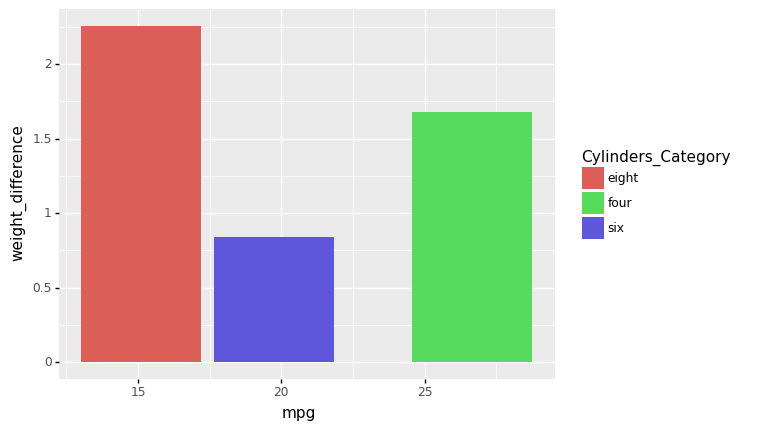

<ggplot: (8782327299503)>

In [43]:
(ggplot(chart_data, aes('mpg', 'weight_difference', fill='Cylinders_Category'))
 + geom_col()
 )